# Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!unzip /content/drive/MyDrive/datasets/coco/train2017.zip -d /content/
!unzip /content/drive/MyDrive/datasets/coco/annotations_trainval2017.zip -d /content

Streaming output truncated to the last 5000 lines.
 extracting: /content/train2017/000000563584.jpg  
 extracting: /content/train2017/000000276069.jpg  
 extracting: /content/train2017/000000401194.jpg  
 extracting: /content/train2017/000000502089.jpg  
 extracting: /content/train2017/000000192183.jpg  
 extracting: /content/train2017/000000425127.jpg  
 extracting: /content/train2017/000000126766.jpg  
 extracting: /content/train2017/000000324161.jpg  
 extracting: /content/train2017/000000452746.jpg  
 extracting: /content/train2017/000000423782.jpg  
 extracting: /content/train2017/000000546343.jpg  
 extracting: /content/train2017/000000249290.jpg  
 extracting: /content/train2017/000000025529.jpg  
 extracting: /content/train2017/000000316928.jpg  
 extracting: /content/train2017/000000337866.jpg  
 extracting: /content/train2017/000000547768.jpg  
 extracting: /content/train2017/000000423162.jpg  
 extracting: /content/train2017/000000224149.jpg  
 extracting: /content/train2017

# Incarcare set date


In [ ]:
from pycocotools.coco import COCO
def load_coco_dataset(annotation_file_path):
  return COCO(annotation_file_path)

# FLIP imagini + adnotari

In [ ]:
import cv2
import numpy as np
import random

from pycocotools import mask

def flip_image_and_annotations(image, annotations):
    h, w = image.shape[:2]
    flip_type = random.choice([0, 1, 2])
    if flip_type == 1:
        flipped_image = cv2.flip(image, 1)
    elif flip_type == 2:
        flipped_image = cv2.flip(image, 0)
    else:
        flipped_image = image.copy()

    flipped_annotations = []
    for annotation in annotations:
        flipped_annotation = annotation.copy()

        if 'segmentation' in annotation:
            if isinstance(annotation['segmentation'], list):
                flipped_segment = []
                for seg in annotation['segmentation']:
                    for i in range(0, len(seg), 2):
                        x, y = seg[i], seg[i+1]
                        if flip_type == 1:
                            x = w - x
                        elif flip_type == 2:
                            y = h - y
                        flipped_segment.extend([x, y])
                flipped_annotation['segmentation'] = [flipped_segment]

            elif isinstance(annotation['segmentation'], dict):  # RLE
                rle = mask.frPyObjects(annotation['segmentation'], h, w)
                rle_mask = mask.decode(rle)

                if flip_type == 1:
                    rle_mask = rle_mask[:, ::-1]
                elif flip_type == 2:
                    rle_mask = rle_mask[::-1, :]

                flipped_annotation['segmentation'] = mask.encode(np.asfortranarray(rle_mask))

        flipped_annotations.append(flipped_annotation)

    return flipped_image, flipped_annotations, flip_type

#ROTATE imagini+ adnotari


In [ ]:
import cv2
import numpy as np
import random
from pycocotools import mask as maskUtils

def rotate_image_and_annotations(image, annotations, angle=None):

    if angle is None:
        angle = random.randint(-30, 30)

    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (w, h))

    rotated_annotations = []

    for annotation in annotations:
        rotated_annotation = annotation.copy()
        x, y, bbox_w, bbox_h = rotated_annotation['bbox']
        corners = np.array([
            [x, y],
            [x + bbox_w, y],
            [x + bbox_w, y + bbox_h],
            [x, y + bbox_h]
        ])
        new_corners = cv2.transform(corners.reshape(-1, 1, 2), M).reshape(-1, 2)
        min_x, min_y = np.min(new_corners, axis=0)
        max_x, max_y = np.max(new_corners, axis=0)

        rotated_annotation['bbox'] = [int(min_x), int(min_y), int(max_x - min_x), int(max_y - min_y)]

        if 'segmentation' in rotated_annotation:
            rotated_segmentation = []
            for segment in rotated_annotation['segmentation']:
                if isinstance(segment, dict) and 'counts' in segment and 'size' in segment:
                    binary_mask = maskUtils.decode(segment)
                    rotated_mask = cv2.warpAffine(binary_mask.astype(np.uint8), M, (w, h))
                    rotated_rle = maskUtils.encode(np.asfortranarray(rotated_mask))
                    rotated_segmentation.append(rotated_rle)
                else:
                    try:
                        if len(segment) >= 2 and len(segment) % 2 == 0:
                            segment_np = np.array(segment).reshape(-1, 1, 2)
                            rotated_segment = cv2.transform(segment_np, M).reshape(-1).tolist()
                            rotated_segmentation.append(rotated_segment)
                    except Exception as e:
                        print(f"An error occurred while processing the segment {segment}: {e}")
            rotated_annotation['segmentation'] = rotated_segmentation
        rotated_annotations.append(rotated_annotation)
    return rotated_image, rotated_annotations, angle

# SHEAR imagini + adnotari


In [ ]:
import cv2
import numpy as np
import random
from pycocotools import mask as maskUtils

def shear_image_and_annotations(image, annotations):
    h, w = image.shape[:2]
    shear_factor = random.uniform(-0.3, 0.3)
    M = np.array([[1, shear_factor, 0], [0, 1, 0]])
    sheared_image = cv2.warpAffine(image, M, (w, h))
    sheared_annotations = []

    for annotation in annotations:
        sheared_annotation = annotation.copy()

        x, y, bbox_w, bbox_h = sheared_annotation['bbox']
        corners = np.array([
            [x, y],
            [x+bbox_w, y],
            [x+bbox_w, y+bbox_h],
            [x, y+bbox_h]
        ])
        new_corners = cv2.transform(corners.reshape(-1, 1, 2), M).reshape(-1, 2)
        min_x = min(new_corners[:, 0])
        min_y = min(new_corners[:, 1])
        max_x = max(new_corners[:, 0])
        max_y = max(new_corners[:, 1])

        sheared_annotation['bbox'] = [int(min_x), int(min_y), int(max_x) - int(min_x), int(max_y - min_y)]

        if 'segmentation' in sheared_annotation:
            sheared_segmentation = []

            for segment in sheared_annotation['segmentation']:
                if isinstance(segment, dict) and 'counts' in segment and 'size' in segment:
                    binary_mask = maskUtils.decode(segment)
                    sheared_mask = cv2.warpAffine(binary_mask.astype(np.uint8), M, (w, h))
                    sheared_rle = maskUtils.encode(np.asfortranarray(sheared_mask))
                    sheared_segmentation.append(sheared_rle)
                else:
                    if len(segment) >= 2 and len(segment) % 2 == 0:
                        segment_np = np.array(segment).reshape(-1, 1, 2)
                        sheared_segment = cv2.transform(segment_np, M).reshape(-1).tolist()
                        sheared_segmentation.append(sheared_segment)
                    else:
                        print(f"Skipping irregular segment with length {len(segment)}")

            sheared_annotation['segmentation'] = sheared_segmentation

        sheared_annotations.append(sheared_annotation)

    return sheared_image, sheared_annotations, shear_factor


# AJUSTARE BBOX


In [ ]:
def adjust_bbox(annotations):
    for annotation in annotations:
        x, y, w, h = annotation['bbox']
        if len(annotation['segmentation']) != 1:
          continue
        segment = annotation['segmentation'][0]
        if len(segment) > 0:
            real_x, real_y = min(segment[0::2]), min(segment[1::2])
            real_w, real_h = max(segment[0::2]) - real_x, max(segment[1::2]) - real_y
            annotation['bbox'] = [real_x, real_y, real_w, real_h]
    return annotations

In [ ]:
def draw_annotations(img, annotations):
    img_annotated = img.copy()

    for ann in annotations:
        bbox = ann["bbox"]
        x, y, w, h = [int(coord) for coord in bbox]
        cv2.rectangle(img_annotated, (x, y), (x + w, y + h), (0, 0, 255), 2)  # BBox in rosu

        if "segmentation" in ann:
            for segment in ann["segmentation"]:
                segment = np.array(segment, dtype=np.int32).reshape((-1, 1, 2))
                cv2.polylines(img_annotated, [segment], isClosed=True, color=(0, 255, 0), thickness=2)  # Segmentare in verde

    return img_annotated

NameError: ignored

# APLICARE TRANSFORMARI


loading annotations into memory...
Done (t=16.94s)
creating index...
index created!
An error occurred while processing the segment size: cannot reshape array of size 1 into shape (1,2)
An error occurred while processing the segment counts: cannot reshape array of size 1 into shape (1,2)


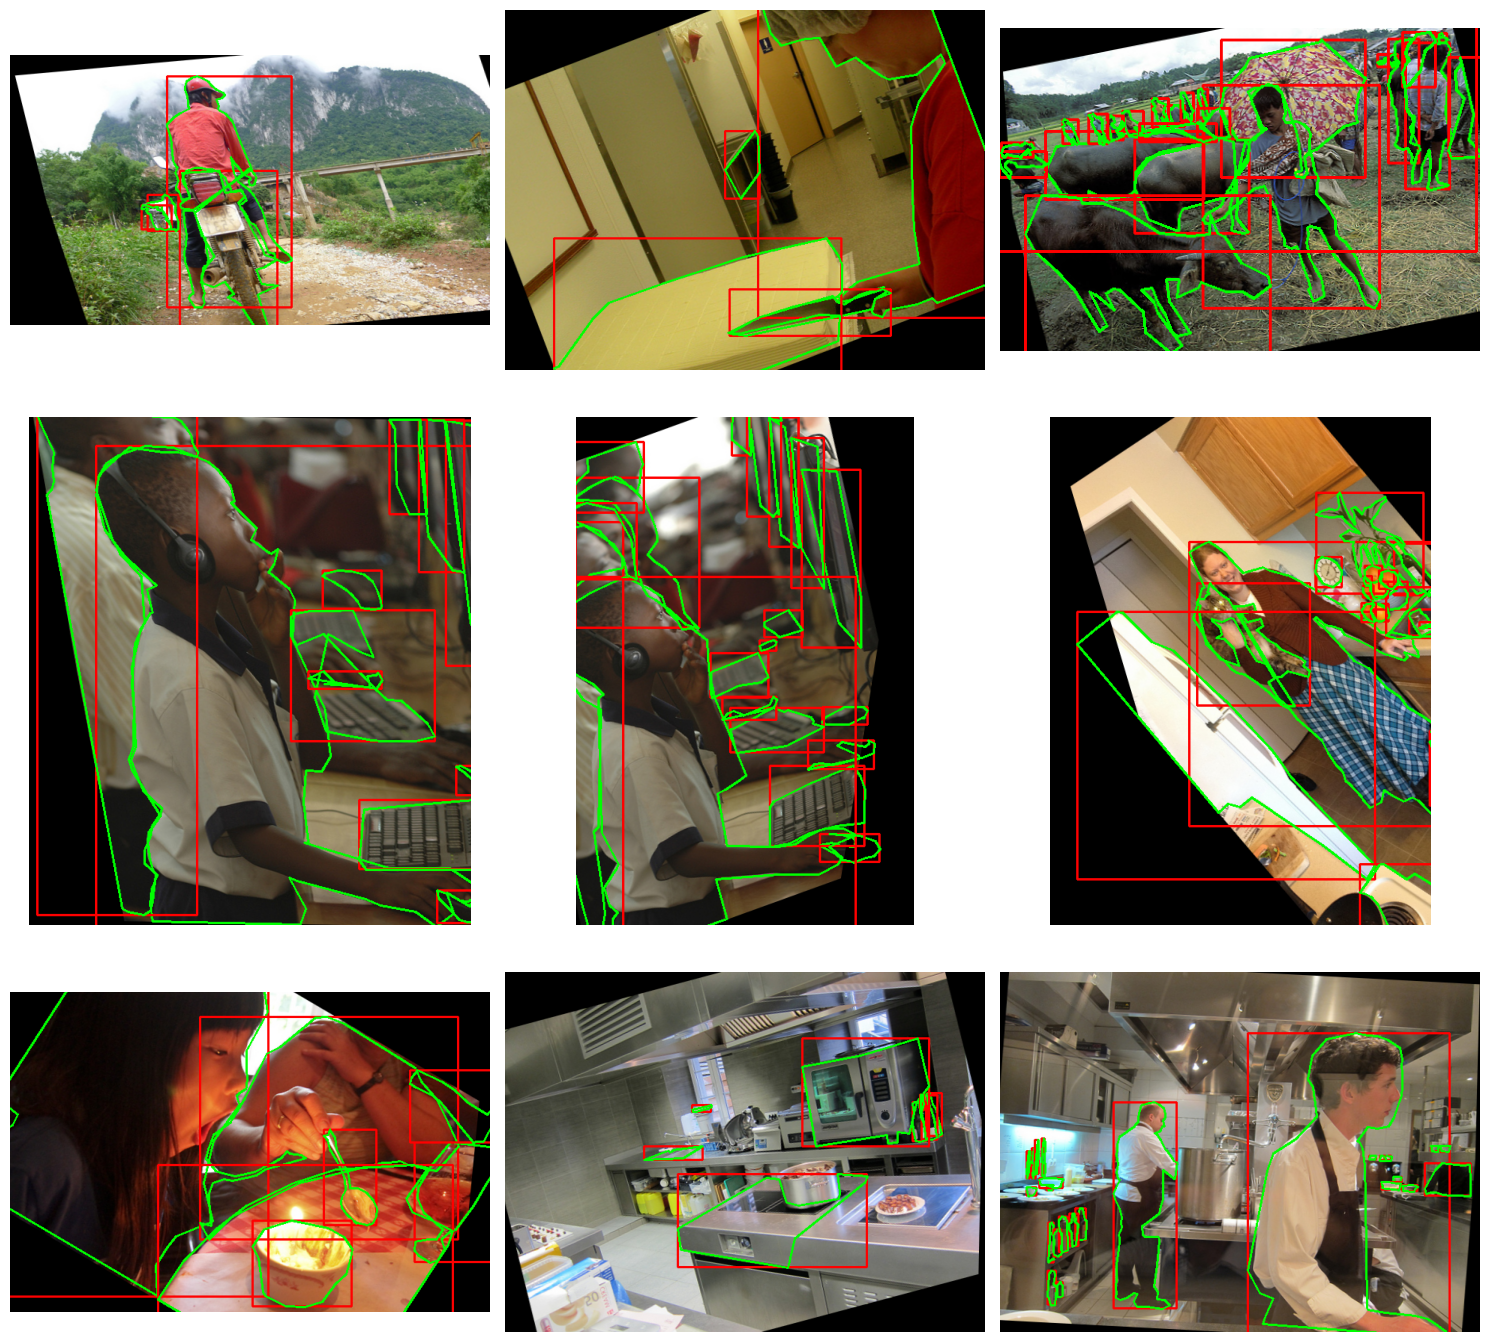

In [ ]:
from pycocotools.coco import COCO
import os
import json
import cv2
import shutil
from matplotlib import pyplot as plt


def apply_transformations(annotations_path, images_folder, new_annotations_path, new_images_folder):
    coco = COCO(annotations_path)

    if not os.path.exists(new_images_folder):
        os.makedirs(new_images_folder)

    new_annotations_data = {
        'images': [],
        'annotations': []
    }

    annotation_id = 1

    k = 0

    for img_id, img_data in coco.imgs.items():
        image_path = os.path.join(images_folder, img_data['file_name'])
        image = cv2.imread(image_path)

        if image is None:
            print(f"Image not found: {image_path}")
            continue

        annotations_ids = coco.getAnnIds(imgIds=img_data['id'])
        annotations = coco.loadAnns(annotations_ids)

        flipped_image, flipped_annotations, _ = flip_image_and_annotations(image, annotations)
        rotated_image, rotated_annotations, _ = rotate_image_and_annotations(flipped_image, flipped_annotations)
        sheared_image, sheared_annotations, _ = shear_image_and_annotations(rotated_image, rotated_annotations)
        sheared_annotations = adjust_bbox(sheared_annotations)

        new_image_path = os.path.join(new_images_folder, img_data['file_name'])
        cv2.imwrite(new_image_path, sheared_image)

        new_img_data = img_data.copy()
        new_img_data['id'] = len(new_annotations_data['images']) + 1
        new_annotations_data['images'].append(new_img_data)

        for annotation in sheared_annotations:
            new_annotation = annotation.copy()
            new_annotation['id'] = annotation_id
            new_annotation['image_id'] = new_img_data['id']
            new_annotations_data['annotations'].append(new_annotation)
            annotation_id += 1

    with open(new_annotations_path, 'w') as f:
        json.dump(new_annotations_data, f)

if __name__ == "__main__":
    data =  apply_transformations(
        annotations_path='/content/annotations/instances_train2017.json',
        images_folder='/content/train2017',
        new_annotations_path='annotations.json',
        new_images_folder='GAN30_augmented_classic'
    )

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for i in range(3):
        for j in range(3):
            idx = i * 3 + j  # Indicele pentru imagine
            img, anns = data[idx]
            annotated_img = draw_annotations(img, anns)

            axes[i, j].imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
coco = COCO("annotations.json")

max_id = max([img['id'] for img in coco.dataset['images']])

for img in coco.dataset['images']:
    max_id += 1
    old_name = img['file_name']
    img['file_name'] = str(max_id).zfill(12) + '.jpg'

    old_id = img['id']
    ann_ids = coco.getAnnIds([old_id])
    anns = coco.loadAnns(ann_ids)
    img['id'] = max_id

    for ann in anns:
        ann['image_id'] = max_id


    old_image_path = os.path.join("/content/GAN30_augmented_classic", old_name)
    new_image_path = os.path.join('/content/GAN30_augmented_classic', img['file_name'])
    shutil.copy2(old_image_path, new_image_path)

output_json_path = '/content/annotations_updated.json'
with open(output_json_path, 'w') as json_file:
    json.dump(coco.dataset, json_file, indent=4)

loading annotations into memory...
Done (t=46.51s)
creating index...
index created!


In [ ]:
coco = COCO("/content/annotations_updated.json")
coco.dataset['annotations'] = [x for x in coco.dataset['annotations'] if x['category_id'] == 1]
with open('annotations_final.json', 'w') as f:
  json.dump(coco.dataset, f)


In [ ]:
import os
import cv2
import numpy as np
from pycocotools.coco import COCO
from google.colab.patches import cv2_imshow


def visualize_random_annotations(image_dir, annotation_file, num_images=1):
    coco = COCO(annotation_file)
    print(len([x for x in coco.dataset['annotations'] if x['category_id'] == 1]))
    # List all files in the image directory
    available_images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    # Filter img_ids based on available_images
    all_img_ids = coco.getImgIds()


    # Select a subset of images to display
    selected_img_ids = np.random.choice(all_img_ids, num_images, replace=False)

    for index, img_id in enumerate(selected_img_ids):
        if index == num_images:
          break

        img_data = coco.loadImgs([img_id])[0]
        img = cv2.imread(os.path.join(image_dir, img_data['file_name']))


        ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=coco.getCatIds(catNms=['person']), iscrowd=None)
        anns = coco.loadAnns(ann_ids)

        for ann in anns:
            if 'bbox' in ann:
                x, y, w, h = map(int, ann['bbox'])
                cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

            if 'segmentation' in ann:
                for segment in ann['segmentation']:
                    if type(segment) == list:  # Ignore the 'counts' key that's not a polygon
                        poly = np.array(segment, np.int32).reshape((-1, 1, 2))
                        cv2.polylines(img, [poly], isClosed=True, color=(0, 255, 0), thickness=2)

        cv2_imshow(img)
# Utilizare:
image_dir = "/content/merged_GAN_images"
num_images = 30

visualize_random_annotations('/content/test_val', "test.json", 20)


# SALVARE


In [ ]:
!zip -q -r rotate_flip_shear.zip train_classic_new/ annotations_final.json
!mv rotate_flip_shear.zip drive/MyDrive/A_new_datasets/